# Tarea 2 - Procesamiento distribuido y redes neuronales profundas

## P1. Carga y transformacion de datos 

In [23]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import skimage.io
from skimage import transform
import torch
import torchvision
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, DataLoader, Sampler, SubsetRandomSampler,RandomSampler   
from torchvision.datasets import DatasetFolder
# Path del directorio
path_dir = os.getcwd()
# Se asigna un valor de reproductibilidad
torch.manual_seed(6202)

# Construcción de función loader

In [24]:
# Función de carga de imagenes de PIL 
def pil_loader(path):
    """ Entrega una imagen en formato PIL a 
    partir de un path.
    
    Args
    ----
    path: str  
        path del origen de la imagen 
    Returns:
        Imagen PIL RGB 
    """
    img = Image.open(path)    
    if img.mode == 'L':
        tensor = transforms.ToTensor()(img)
        tensor_RGB = torch.cat((tensor, tensor, tensor), 0)
        return transforms.ToPILImage()(tensor_RGB) 
    else:
        return img
    
# Funcion de carga de imagenes con skimage 
def skimage_loader(path):
    """ Entrega una imagen en formato array a 
    partir de un path.
    
    Args
    ----
    path: str  
        path del origen de la imagen 
    Returns:
        Array de 3 canales compatible con skimage. 
    """
    img = skimage.io.imread(fname=(path))    
    if len(img.shape) == 2:
        img_reshape =  img.reshape((img.shape[0], img.shape[1],1))
        img_3_canales = np.concatenate((img_reshape,img_reshape,img_reshape),axis=2)
        return img_3_canales 
    else:
        return img

In [25]:
# Transformaciones para imagen Pil o array:
# funcion para escalar a una imagen de 224x224
def Transform_Resize(library = 'PyTorch'):
    if library == 'PyTorch':
        return transforms.Resize((224, 224))
    elif library == 'skimage':
        skimage_resize = lambda imagen: transform.resize(imagen, (224, 224))
        return skimage_resize

# funcion para voltear imagen con probabilidad 0.5
def Transform_Flip(library = 'PyTorch'):
    if library == 'PyTorch':
        return transforms.RandomVerticalFlip(0.5)
    elif library == 'skimage':
        return lambda imagen: np.flipud(imagen) if (np.random.random()<0.5) else imagen
    
# Funcion para rotar la imagen con un angulo random entre (-20, 20) 
def Transform_Rotation(library = 'PyTorch'):
    if library == 'PyTorch':
        return transforms.RandomRotation((-20, 20))
    elif library == 'skimage':
        return lambda imagen: transform.rotate(imagen,(np.random.random()*40)-20,resize=False)
    
# Transformaciones para tensor:
# funcion para escalar los valores del brillo de la imagen     
def Transform_Scale(tensor, library = 'PyTorch'):
    if library == 'PyTorch':
        return torch.div(tensor, torch.max(tensor))
    elif library == 'skimage':
        return tensor / (np.max(tensor))

def Transform_Mult(tensor, library = 'PyTorch'):
    if library == 'PyTorch':
        random_tensor = 0.3*torch.rand((3,224, 224)) + 1.2 
        return torch.mul(tensor, random_tensor) 
    elif library == 'skimage':
        random_array = (0.3*np.random.random_sample((224,224,3))) + 1.2 
        return np.multiply(tensor, random_array) 

In [26]:
# Listas de transformaciones
transform_torchvision = transforms.Compose([Transform_Resize(),
                                Transform_Flip(),
                                Transform_Rotation(),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: Transform_Scale(x)),
                                transforms.Lambda(lambda x: Transform_Mult(x))]) 
transform_skimage = transforms.Compose([Transform_Resize('skimage'),
                                Transform_Flip('skimage'),
                                Transform_Rotation('skimage'),
                                transforms.Lambda(lambda x: Transform_Scale(x,'skimage')),
                                transforms.Lambda(lambda x: Transform_Mult(x,'skimage')),
                                transforms.ToTensor()]) 

In [27]:
# Funcion que entrega objetos data_set para train y test 
def loader(data_set_name, image_loader, transform):
    if data_set_name == 'Train':
        root_path = path_dir + '\\Data\\chest_xray\\train'
        # Cargar el data_set train y el data_set test
        data_set_train = DatasetFolder(root_path, image_loader,
                                       extensions=('.jpeg', '.JPEG'),
                                       transform = transform)
        return data_set_train
    elif data_set_name == 'Test':
        root_path = path_dir + '\\Data\\chest_xray\\test'
        # Cargar el data_set train y el data_set test
        data_set_test = DatasetFolder(root_path, image_loader,
                                       extensions=('.jpeg', '.JPEG'),
                                       transform = transform)
        return data_set_test

In [28]:
# Cargar ambos, el data_set train y el data_set test
data_set_train = loader('Train', skimage_loader, transform_skimage)
data_test = loader('Test', skimage_loader, transform_skimage)

# Visualización de distribución de datos

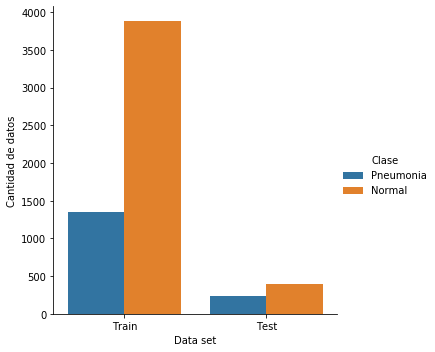

In [29]:
# Cantidad de muestras en train
train_len = len(data_set_train)
# Largos de data sets
len_train_0 = len([data_set_train.samples[i][1] for i in range(len(data_set_train)) 
                   if (data_set_train.samples[i][1] == 0)])
len_train_1 = len([data_set_train.samples[i][1] for i in range(len(data_set_train)) 
                   if (data_set_train.samples[i][1] == 1)])
len_test_0 = len([data_test.samples[i][1] for i in range(len(data_test)) 
                   if (data_test.samples[i][1] == 0)])
len_test_1 = len([data_test.samples[i][1] for i in range(len(data_test)) 
                   if (data_test.samples[i][1] == 1)])
# plotear distribuciones de datos
data_plot = {'Data set':  ['Train','Train','Test','Test'],
        'Clase': ['Pneumonia','Normal','Pneumonia','Normal'],
        'Cantidad de datos': [len_train_0,len_train_1,len_test_0,len_test_1]}
df_plot = pd.DataFrame(data_plot, columns = ['Data set','Clase','Cantidad de datos'])
# Plotear gráficos de barra
sns.axes_style("darkgrid")
sns_plot = sns.catplot(x='Data set', y='Cantidad de datos', hue='Clase', data=df_plot, kind='bar')
# sns_plot.savefig("Distribución de datos.png",dpi=400)

# Construcción de clase ReplicarMuestreoDePrueba

In [30]:
data_train, data_valid = random_split(data_set_train, [int(train_len*0.8),
                                                                 train_len - int(train_len*0.8)])

In [31]:
class ReplicarMuestreoDePrueba(Sampler):
    def __init__(self, etiquetas_prueba, indices_val, etiquetas_val):
        self.etiquetas_prueba = etiquetas_prueba
        self.indices_val = indices_val 
        self.etiquetas_val = etiquetas_val
        self.indices_val_iter = indices_val 
        self.val_prob_normal = etiquetas_val.count(0)/len(etiquetas_val)
        self.val_prob_pneumo = etiquetas_val.count(1)/len(etiquetas_val)
        self.test_prob_normal = etiquetas_prueba.count(0)/len(etiquetas_prueba)
        self.test_prob_pneumo = etiquetas_prueba.count(1)/len(etiquetas_prueba)
    def __iter__(self):
        if self.val_prob_pneumo <= self.test_prob_pneumo:
            # etiquetas pneumo a agregar
            plus = SubsetRandomSampler(((len(self.etiquetas_val)*self.test_prob_pneumo)
                        -self.etiquetas_val.count(1))/(1-self.test_prob_pneumo))
            # Agregar 'plus' indices de neumonia uniforme  
            indices_val_pneumo = [self.indices_val[i] for i in range(len(self.indices_val)) 
                                  if self.etiquetas_val[i] == 1]
            # Append    
            index_plus = np.random.choice(indices_val_pneumo, plus, replace=True)
        else:
            # agregar normal al neumos
            plus = int(((len(self.etiquetas_val)*self.test_prob_normal)
                        -self.etiquetas_val.count(0))/(1-self.test_prob_normal))
            # Agregar 'plus' indices de normal uniforme  
            indices_val_normal = [self.indices_val[i] for i in range(len(self.indices_val)) 
                                  if self.etiquetas_val[i] == 0]
            # Append
            index_plus = np.random.choice(indices_val_normal, plus, replace=True)
        return iter(self.indices_val_iter + list(index_plus))

In [32]:
etiquetas_prueba = data_test.targets
indices_val = data_valid.indices
etiquetas_val = [data_set_train.targets[i] for i in data_valid.indices] 
# inicializar iterator para valid
RMP = ReplicarMuestreoDePrueba(etiquetas_prueba, indices_val, etiquetas_val)

In [33]:
batch_size = 5
loader_data_train = DataLoader(data_set_train, batch_size=batch_size,
                               sampler= SubsetRandomSampler(data_train.indices))
loader_data_valid = DataLoader(data_set_train, batch_size=batch_size, sampler=RMP)
loader_data_test = DataLoader(data_test, batch_size=batch_size)

# Pruebas de tiempo

In [34]:
# Prueba de tiempo
def unpacking_dataloader(data_loader, n):
    for i_batch, sample_batched in enumerate(data_loader):
        if i_batch == n:
            break

In [40]:
# datasets con skimage y tochvision
data_set_skimage = loader('Train', skimage_loader, transform_skimage)
data_set_torchvision = loader('Train', pil_loader, transform_torchvision)
# dataloader con skimage y dataloader con tochvision
batch_size = 5
loader_data_skimage = DataLoader(data_set_skimage, batch_size=batch_size, shuffle=True)
loader_data_torchvision = DataLoader(data_set_torchvision, batch_size=batch_size, shuffle=True)

In [46]:
# Tiempo de carga total para loader_data_skimage 
# %prun unpacking_dataloader(loader_data_skimage,0)
# 7676 function calls (7578 primitive calls) in 0.912 seconds
# 10    0.325    0.032    0.325    0.032 {built-in method scipy.ndimage._nd_image.correlate1d}
# Tiempo de carga total para loader_data_torchvision 
# %prun unpacking_dataloader(loader_data_torchvision,0)
# 2354 function calls (2351 primitive calls) in 0.486 seconds
#  163    0.214    0.001    0.214    0.001 {method 'read' of '_io.BufferedReader' objects}
# probar con una imagen 
path = path_dir + '\\Data\\chest_xray\\train\\PNEUMONIA\\person1010_virus_1695.jpeg'

In [47]:
# tiempo en cargar una imagen con pil
%prun pil_loader(path)
# 175 function calls in 0.012 seconds
# 39    0.010    0.000    0.010    0.000 {method 'read' of '_io.BufferedReader' objects}

In [48]:
# tiempo en cargar una imagen con skimage
%prun skimage_loader(path)
# 684 function calls in 0.006 seconds
# 1    0.002    0.002    0.002    0.002 {method 'decode' of 'ImagingDecoder' objects}

In [62]:
# Transform_Resize time
pil_image = pil_loader(path)
skimage_image = skimage_loader(path)

In [54]:
%prun Transform_Resize(library = 'PyTorch')(pil_image)
# 50 function calls in 0.005 seconds
# 1    0.002    0.002    0.002    0.002 {method 'decode' of 'ImagingDecoder' objects}

In [55]:
%prun Transform_Resize(library = 'skimage')(skimage_image)
# 541 function calls (526 primitive calls) in 0.020 seconds
# 1    0.008    0.008    0.015    0.015 _warps.py:666(warp)

In [63]:
# Transform_Resize time
pil_image = Transform_Resize(library = 'PyTorch')(pil_image)
skimage_image = Transform_Resize(library = 'skimage')(skimage_image)

In [57]:
%prun Transform_Flip(library = 'PyTorch')(pil_image)
# 17 function calls in 0.000 seconds
# 1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}

In [60]:
%prun Transform_Flip(library = 'skimage')(skimage_image)
# 12 function calls in 0.000 seconds
# 1    0.000    0.000    0.000    0.000 <ipython-input-25-3e18e36632c1>:15(<lambda>)

In [64]:
# Transform_Flip time
pil_image = Transform_Flip(library = 'PyTorch')(pil_image)
skimage_image = Transform_Flip(library = 'skimage')(skimage_image)

In [65]:
%prun Transform_Rotation(library = 'PyTorch')(pil_image)
# 63 function calls in 0.001 seconds
# 1    0.000    0.000    0.000    0.000 {built-in method PIL._imaging.fill}

In [68]:
%prun Transform_Rotation(library = 'skimage')(skimage_image)
# 154 function calls (150 primitive calls) in 0.014 seconds
# 1    0.009    0.009    0.014    0.014 _warps.py:666(warp)

In [69]:
# Transform_Flip time
pil_image = Transform_Rotation(library = 'PyTorch')(pil_image)
skimage_image = Transform_Rotation(library = 'skimage')(skimage_image)

In [70]:
# imagen a tensor
pil_image = transforms.ToTensor()(pil_image)

In [71]:
%prun Transform_Scale(pil_image, library = 'PyTorch')
# 6 function calls in 0.001 seconds
# 1    0.001    0.001    0.001    0.001 {built-in method max}

In [72]:
%prun Transform_Scale(skimage_image, library = 'skimage')
# 12 function calls in 0.001 seconds
# 1    0.001    0.001    0.001    0.001 <ipython-input-25-3e18e36632c1>:26(Transform_Scale)

In [73]:
# Transform_Flip time
pil_image = Transform_Scale(pil_image, library = 'PyTorch')
skimage_image = Transform_Scale(skimage_image, library = 'skimage')

In [75]:
%prun Transform_Mult(pil_image, library = 'PyTorch')
# 6 function calls in 0.002 seconds
# 1    0.001    0.001    0.001    0.001 {built-in method rand}

In [76]:
%prun Transform_Mult(skimage_image, library = 'skimage')
# 5 function calls in 0.005 seconds
# 1    0.002    0.002    0.004    0.004 <ipython-input-25-3e18e36632c1>:32(Transform_Mult)

# P2